In [1]:
import tables
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

# input glob ignored if recipe is already run.
# NOTE - change extension to .tiff to trigger bioformats i/o and get color channels/metadata in correctly
input_glob = '/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/STED_CBs_stacks/*.tiff'
# results directory will be made by the program and filled. If it already exists, we assume the analysis recipe has already run
result_directory = '/media/smeagol/SSD/sted_cb_offset/no_jvm_kill_no_minsize_label'
run_recipe = not os.path.exists(result_directory)
if run_recipe:
    print('no results found, will generate them in next cell')

In [2]:
if run_recipe:  # PYME is only required if we need to run the recipe, import here
    from PYME.recipes.base import ModuleCollection
    from PYME.recipes import batchProcess
    import quant_condensate
    
    recipe_path = os.path.join(os.path.dirname(os.path.abspath(quant_condensate.__file__)),
                               'recipes', 'offset_measure3d_nolabel.yaml')
    with open(recipe_path) as f:
        contents = f.read()
    recipe = ModuleCollection().fromYAML(contents)
    
    try:
        os.mkdir(result_directory)
    except:
        raise RuntimeError('Output directory already exists; exiting to avoid accidental replacement/appending to outputs')

    logger.addHandler(logging.FileHandler(os.path.join(result_directory, 'logging.txt')))
    logger.debug('initializing file logging')
    
    input_globs = {
        'input': glob.glob(input_glob)
    }
    print('%d inputs found' % len(input_globs['input']))
    batchProcess.bake(recipe, input_globs, result_directory, num_procs=1)

In [3]:
# load and analyze results
files = glob.glob(os.path.join(result_directory, '*.hdf'))
d = dict()
look_at = ['offset', 'fractional_volume_overlap', 'fractional_intensity_overlap', 'intensity_total']



for f in files:
    vals = os.path.split(os.path.splitext(f)[0])[-1].split('_')
    treat = vals[2]
    
    if treat not in d.keys():
        d[treat] = dict(path=[], conf={}, sted={})
        for k in look_at:
            d[treat]['conf'][k] = list()
            d[treat]['sted'][k] = list()
    
    d[treat]['path'].append(f)
    
    t = tables.open_file(f)
    conf = t.root.confocal[:]
    sted = t.root.sted[:]
    
    # grab what we care about
    for k in look_at:
        d[treat]['conf'][k].append(conf[0][k])
        d[treat]['sted'][k].append(sted[0][k])
    if not (('SMN' in vals[0] and 'Coilin' in vals[1]) or ('SMN' in vals[1] and 'Coilin' in vals[0])):
        raise ValueError('unknown labeling')
    
    t.close()

Text(0, 0.5, 'Offset [nm]')

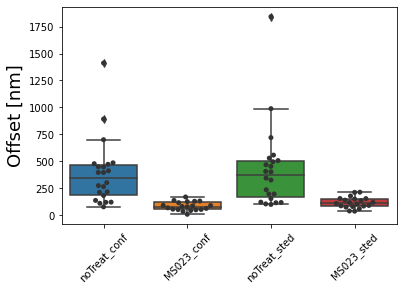

In [5]:
off = {
    'noTreat_conf': d['noTreat']['conf']['offset'],
    'MS023_conf': d['MS023']['conf']['offset'],
    'noTreat_sted': d['noTreat']['sted']['offset'],
    'MS023_sted': d['MS023']['sted']['offset'],
}

off_keys = list(off.keys())
plt.figure()
sns.boxplot(data=[off[k] for k in off_keys])
sns.swarmplot(data=[off[k] for k in off_keys], color=".2")
plt.xticks(plt.xticks()[0], off_keys, rotation=45)
plt.ylabel('Offset [nm]', fontsize=18)

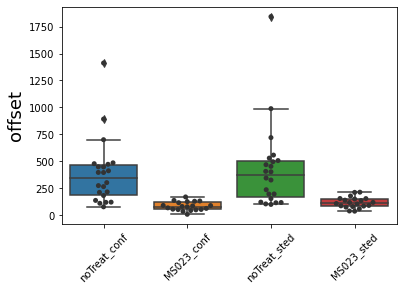

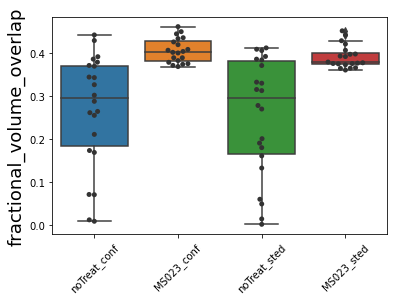

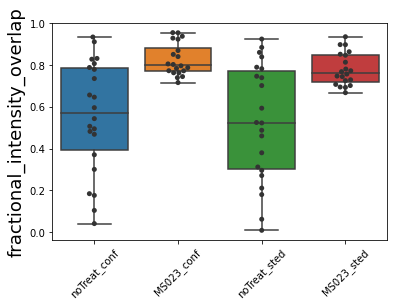

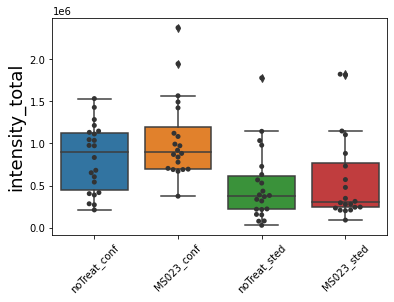

In [6]:
for k in look_at:
    to_plot = {}
    plot_keys = []
    for modality in ('conf', 'sted'):
        for treat in d.keys():
            plot_key = treat + '_' + modality
            plot_keys.append(plot_key)
            to_plot[plot_key] = d[treat][modality][k]
    

    plt.figure()
    sns.boxplot(data=[to_plot[pk] for pk in plot_keys])
    sns.swarmplot(data=[to_plot[pk] for pk in plot_keys], color=".2")
    plt.xticks(plt.xticks()[0], plot_keys, rotation=45)
    plt.ylabel(k, fontsize=18)